In [1]:
pwd

'/Users/edwardterrell/Desktop/Training/kindle/strava'

In [2]:
import requests
import json
import time
import os
from pprint import pprint

import pandas as pd
pd.set_option('display.precision', 1)
import warnings
warnings.filterwarnings("ignore", message=".*will drop timezone.*")

%matplotlib inline
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

%load_ext autoreload
%autoreload 2
from clean_convert import cleanup, convert_speed, order_columns
from zones import get_zones_for_id

# import graphics programs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,6)}) # for all future plots

import sys
sys.executable

'/Users/edwardterrell/opt/anaconda3/envs/mlml/bin/python'

In [3]:
from token_manager import get_valid_access_token
import requests

access_token = get_valid_access_token()
print("Using access token:", access_token)

# Make an authenticated API call
response = requests.get(
    'https://www.strava.com/api/v3/athlete',
    headers={'Authorization': f'Bearer {access_token}'}
)
print(response.json())

Using access token: 559777818dc4246bbe5d00cc7ee45f623168a671
{'id': 723727, 'username': 'eterrell', 'resource_state': 2, 'firstname': 'Ed', 'lastname': 'Terrell', 'bio': '', 'city': 'Boulder', 'state': 'CO', 'country': 'United States', 'sex': 'M', 'premium': True, 'summit': True, 'created_at': '2012-07-05T00:04:09Z', 'updated_at': '2025-07-09T12:38:59Z', 'badge_type_id': 1, 'weight': 61.235, 'profile_medium': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/medium.jpg', 'profile': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/large.jpg', 'friend': None, 'follower': None}


In [5]:
# Get activities from Jan 1, 2025 onward
start_date = int(time.mktime(time.strptime('2025-01-01', '%Y-%m-%d')))

url = "https://www.strava.com/api/v3/athlete/activities"
headers = {"Authorization": f"Bearer {access_token}"}
params = {
    "after": start_date,
    "per_page": 200,  # max per request
    "page": 1
}
activities = []
while True:
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    if not data:
        break
    activities.extend(data)
    params["page"] += 1


# Build out strava_df with only the necessary columns
strava_df = pd.DataFrame(activities)
cols_needed = ['id','name', 'distance', 'moving_time','total_elevation_gain', 'sport_type',
          'average_speed', 'average_heartrate','max_heartrate', 'suffer_score','start_date']
strava_df = strava_df.loc[:,cols_needed]
strava_df = strava_df.sort_values('start_date',ascending=False) 
strava_df.head()

,id,name,distance,moving_time,total_elevation_gain,sport_type,average_speed,average_heartrate,max_heartrate,suffer_score,start_date
127,15093410751,Gross Reservoir Loop Hwy72 - CR97 and Magnolia,90130.9,19673,1917.2,Ride,4.6,113.3,141.0,233.0,2025-07-12T13:45:47Z
126,15061307314,Nederland exploration and exploitation,54140.4,11638,993.7,Ride,4.7,109.1,131.0,106.0,2025-07-09T14:17:28Z
125,15048399185,Jamestown and eats at Lucky's Bakery,60380.4,9467,757.0,Ride,6.4,110.9,140.0,101.0,2025-07-08T14:44:02Z
124,15037283785,Old Stage,44640.8,7128,430.0,Ride,6.3,109.6,134.0,54.0,2025-07-07T12:38:38Z
123,15027982989,North dirt roads to Longmont bike paths and Ba...,59511.9,10021,361.6,Ride,5.9,102.5,129.0,47.0,2025-07-06T14:14:42Z


### Build strava_df from activities

In [6]:
# drop activities where no heartrate data was collected
strava_df = strava_df.dropna(subset=['average_heartrate'])
#strava_df.head(2)

# process data with function cleanup (from clean_convert.py)
cleanup (strava_df)

# add column: converted_speed ride-mph  and run-min/mile  (from clean_convert.py)
strava_df['converted_speed'] = strava_df.apply(convert_speed, axis=1)

strava_df = order_columns(strava_df)
strava_df.head(2)

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score,time-minutes,average_speed,start_date
127,15093410751,Gross Reservoir Loop Hwy72 - CR97 and Magnolia,2025-07-12,Ride,56.0,5:27,10.2,6290.0,113.3,141.0,233.0,327.9,4.6,2025-07-12 13:45:47+00:00
126,15061307314,Nederland exploration and exploitation,2025-07-09,Ride,33.6,3:13,10.4,3260.2,109.1,131.0,106.0,194.0,4.7,2025-07-09 14:17:28+00:00


### Dataframe approach to create strava_zone_df

In [7]:
# Create a zone dataframe
cols = ['id', 'name', 'date', 'suffer_score','start_date']
#data = strava_df.iloc[:,[0,1,2,-4,-1]]
data = strava_df.loc[:,cols]
strava_zone_df = pd.DataFrame(data, columns=cols)
strava_zone_df.tail(1)

,id,name,date,suffer_score,start_date
0,13267843983,Sanitas ridge - Lion's Lair return w/J,2025-01-04,203.0,2025-01-04 16:59:01+00:00


In [8]:
activity_ids = strava_df['id'].tolist()

# Split into two batches
batch1 = activity_ids[:64]
batch2 = activity_ids[64:]

# Process batch 1
zone_data_1 = [get_zones_for_id(current_id, access_token) for current_id in batch1]

# Sleep 15 minutes to avoid rate limit
print("Sleeping for 16 minutes to respect Strava rate limit...")
time.sleep(16 * 60)

# Process batch 2
zone_data_2 = [get_zones_for_id(current_id, access_token) for current_id in batch2]

In [24]:
# Combine results into one DataFrame
all_zone_data = zone_data_1 + zone_data_2
zone_df = pd.DataFrame(all_zone_data,index=batch1 + batch2 )

In [25]:
zone_df.head(3)

,Zone1,Zone2,Zone3,Zone4,Zone5
15093410751,22.3,222.0,82.0,1.6,0.0
15061307314,31.9,132.7,29.4,0.0,0.0
15048399185,21.4,109.4,26.1,0.8,0.0


In [22]:
zone_df = zone_df.reset_index()
zone_df.columns = ['id', 'Zone1', 'Zone2', 'Zone3', 'Zone4', 'Zone5']

In [23]:
zone_df.head(2)

,id,Zone1,Zone2,Zone3,Zone4,Zone5
0,15093410751,22.3,222.0,82.0,1.6,0.0
1,15061307314,31.9,132.7,29.4,0.0,0.0


In [17]:
strava_zone_df.head()

,id,name,date,suffer_score,start_date
127,15093410751,Gross Reservoir Loop Hwy72 - CR97 and Magnolia,2025-07-12,233.0,2025-07-12 13:45:47+00:00
126,15061307314,Nederland exploration and exploitation,2025-07-09,106.0,2025-07-09 14:17:28+00:00
125,15048399185,Jamestown and eats at Lucky's Bakery,2025-07-08,101.0,2025-07-08 14:44:02+00:00
124,15037283785,Old Stage,2025-07-07,54.0,2025-07-07 12:38:38+00:00
123,15027982989,North dirt roads to Longmont bike paths and Ba...,2025-07-06,47.0,2025-07-06 14:14:42+00:00


In [26]:
# Add in summary zones: moderate and intense
zone_df['moderate'] = zone_df[['Zone1', 'Zone2']].sum(axis=1)
zone_df['intense'] = zone_df[['Zone3', 'Zone4', 'Zone5']].sum(axis=1)

In [30]:
# zone_df.head()
# concat both dfs
strava_zone_df = pd.merge(strava_zone_df, zone_df, left_on='id',right_index=True)

In [31]:
# Get the Sunday start of the week for each date (time set to midnight)
strava_zone_df['week_start'] = strava_zone_df['start_date'].dt.to_period('W-SUN').dt.start_time

In [32]:
strava_zone_df.head(5)

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start
127,15093410751,Gross Reservoir Loop Hwy72 - CR97 and Magnolia,2025-07-12,233.0,2025-07-12 13:45:47+00:00,22.3,222.0,82.0,1.6,0.0,244.3,83.6,2025-07-07
126,15061307314,Nederland exploration and exploitation,2025-07-09,106.0,2025-07-09 14:17:28+00:00,31.9,132.7,29.4,0.0,0.0,164.6,29.4,2025-07-07
125,15048399185,Jamestown and eats at Lucky's Bakery,2025-07-08,101.0,2025-07-08 14:44:02+00:00,21.4,109.4,26.1,0.8,0.0,130.8,26.9,2025-07-07
124,15037283785,Old Stage,2025-07-07,54.0,2025-07-07 12:38:38+00:00,2.6,104.8,11.4,0.0,0.0,107.3,11.4,2025-07-07
123,15027982989,North dirt roads to Longmont bike paths and Ba...,2025-07-06,47.0,2025-07-06 14:14:42+00:00,16.4,149.1,1.5,0.0,0.0,165.5,1.5,2025-06-30


In [33]:
# Temporarily sort ascending by week_start and date to compute cumulative sum correctly
temp = strava_zone_df.sort_values(['week_start', 'start_date'], ascending=[True, True])

# Calculate cumulative sum within each week
cumulative_cols = ['intense', 'moderate', 'suffer_score']
cumulative_sums = (
    temp
    .groupby('week_start')[cumulative_cols]
    .cumsum()
    .add_prefix('weekly_')  # rename columns if needed
)
strava_zone_df = strava_zone_df.join(cumulative_sums)

In [34]:
keep_cols = ['id', 'name', 'date', 'suffer_score', 'moderate', 'intense',
       'weekly_intense','weekly_moderate','weekly_suffer_score']

In [35]:
strava_zone_df[keep_cols].head()

,id,name,date,suffer_score,moderate,intense,weekly_intense,weekly_moderate,weekly_suffer_score
127,15093410751,Gross Reservoir Loop Hwy72 - CR97 and Magnolia,2025-07-12,233.0,244.3,83.6,151.4,647.0,494.0
126,15061307314,Nederland exploration and exploitation,2025-07-09,106.0,164.6,29.4,67.8,402.8,261.0
125,15048399185,Jamestown and eats at Lucky's Bakery,2025-07-08,101.0,130.8,26.9,38.4,238.2,155.0
124,15037283785,Old Stage,2025-07-07,54.0,107.3,11.4,11.4,107.3,54.0
123,15027982989,North dirt roads to Longmont bike paths and Ba...,2025-07-06,47.0,165.5,1.5,143.9,794.7,597.0


In [36]:
week_summary = (
    strava_zone_df
    .groupby('week_start')[['weekly_intense','weekly_moderate','weekly_suffer_score']]
    .max()
    .reset_index()
)
# Format weeks as strings (e.g. 'Jul 01', 'Jul 08')
week_summary["week"] = week_summary["week_start"].dt.strftime('%b %d')
week_summary.head(3)

,week_start,weekly_intense,weekly_moderate,weekly_suffer_score,week
0,2024-12-30,79.8,21.1,203.0,Dec 30
1,2025-01-06,95.1,82.3,230.0,Jan 06
2,2025-01-13,92.1,343.2,335.0,Jan 13


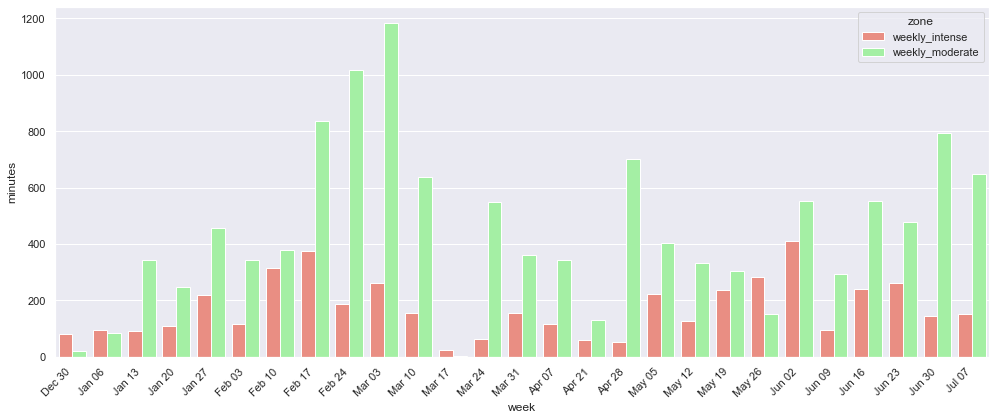

In [37]:
# Melt the DataFrame to long format and plot
long_df = pd.melt(
    week_summary,
    id_vars="week",
    value_vars=["weekly_intense", "weekly_moderate"],
    var_name="zone",
    value_name="minutes"
)
#long_df.head()

plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data=long_df,
    x="week",
    y="minutes",
    hue="zone",
    palette={"weekly_intense": "salmon", "weekly_moderate": "palegreen"}
)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

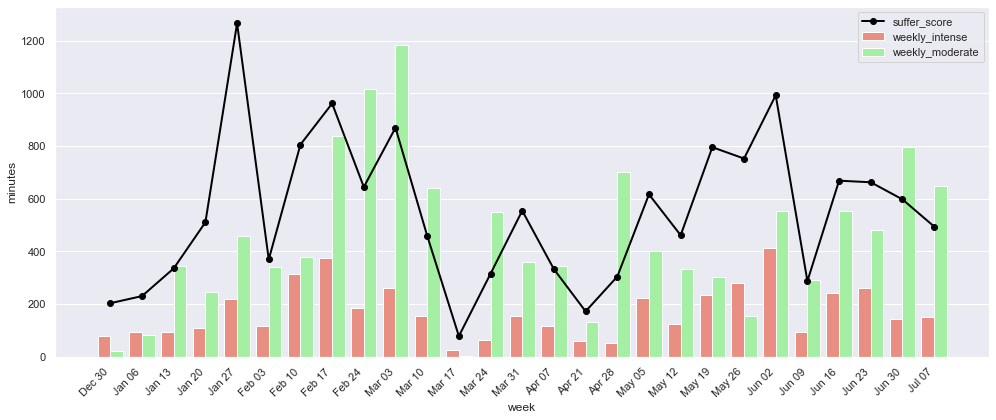

In [38]:
# Add a line plot on top 
plt.figure(figsize=(14, 6))
# Add line plot with a label
ax = sns.barplot(
    data=long_df,
    x="week",
    y="minutes",
    hue="zone",
    palette={"weekly_intense": "salmon", "weekly_moderate": "palegreen"}
)
line = ax.plot(
    week_summary["week"],
    week_summary["weekly_suffer_score"],
    color="black",
    marker="o",
    linewidth=2,
    label="suffer_score"  
)
# Create the legend manually from all handles
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

# Optional: improve layout
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.legend()
plt.show()

In [39]:
strava_df.head(3)

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score,time-minutes,average_speed,start_date
127,15093410751,Gross Reservoir Loop Hwy72 - CR97 and Magnolia,2025-07-12,Ride,56.0,5:27,10.2,6290.0,113.3,141.0,233.0,327.9,4.6,2025-07-12 13:45:47+00:00
126,15061307314,Nederland exploration and exploitation,2025-07-09,Ride,33.6,3:13,10.4,3260.2,109.1,131.0,106.0,194.0,4.7,2025-07-09 14:17:28+00:00
125,15048399185,Jamestown and eats at Lucky's Bakery,2025-07-08,Ride,37.5,2:37,14.3,2483.6,110.9,140.0,101.0,157.8,6.4,2025-07-08 14:44:02+00:00


In [40]:
strava_zone_df.head(3)

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
127,15093410751,Gross Reservoir Loop Hwy72 - CR97 and Magnolia,2025-07-12,233.0,2025-07-12 13:45:47+00:00,22.3,222.0,82.0,1.6,0.0,244.3,83.6,2025-07-07,151.4,647.0,494.0
126,15061307314,Nederland exploration and exploitation,2025-07-09,106.0,2025-07-09 14:17:28+00:00,31.9,132.7,29.4,0.0,0.0,164.6,29.4,2025-07-07,67.8,402.8,261.0
125,15048399185,Jamestown and eats at Lucky's Bakery,2025-07-08,101.0,2025-07-08 14:44:02+00:00,21.4,109.4,26.1,0.8,0.0,130.8,26.9,2025-07-07,38.4,238.2,155.0


In [41]:
# Save both
strava_df.to_pickle("strava_data.pkl")
zone_df.to_pickle("zone_data.pkl")

print("All data saved.")

All data saved.
